# SEVIR Tutorial

The Storm EVent ImagRy (SEVIR) dataset is a collection of temporally and spatially aligned weather images.  This dataset was created using publically available datasets that are distributed by NOAA. This tutorial provides information about the SEVIR dataset as well as sample code to accesses the data.

This animations shows one of thousands of samples in the SEVIR dataset.   Each of these "events" consists of 4 hours of data in 5 minute time increments over a 384 km x 384 km patch sampled over the US:

<p>
    <center><img src="tutorial_img/sevir_sample.gif" alt="sev_samp"/></center>
        <center><em>Figure 1:  Sample event in the SEVIR dataset</em> </center>
</p>


The tutorial contains the following 

* [SEVIR Overview](#overview)
* [Data organization](#files)
* [Accessing raster types](#rasters)
* [Accessing lightning](#lightning)
* [Additional resources](#additional)

</div>

## SEVIR Overview <a class="anchor" id="overview"></a>

The size and complexity of weather data can make it difficult to work with.  The SEVIR dataset was constructed to enable faster R&D in areas of weather sensing and short-term forecasting.  SEVIR combines and aligns multiple weather sensing modalities into a single accessible dataset that can be used by meterologists, data scientists and other researchers.  

SEVIR is a collection of thousands of "events", which are 4-hour sequences of weather captured by up to 5 sensors.   These 5 sensing modalities are summarized in the table below:


| Sensor | Data key | Description | Spatial Resolution |  Patch Size |  Time step | Sample Colorized Image |
|:--------:|:------:|:-------------:|:--------------------:|:---------:|:-----------:|:------:|
|  GOES-16 C02 0.64 $\mu m$  |`vis`  |  Visible satellite imagry |  0.5 km | 768x768 | 5 minute   |      <img src="tutorial_img/vis_sample.png" width="80" height="80" />        |
|  GOES-16 C09 6.9 $\mu m$  |`ir069`   |  Infrared Satellite imagry (Water Vapor) | 2 km | 192 x 192  | 5 minutes         |     <img src="tutorial_img/ir069_sample.png" width="80" height="80" />        |
|  GOES-16 C13 10.7 $\mu m$  |`ir107`   |  Infrared Satellite imagry (Window) | 2 km | 192 x 192  | 5 minutes         |     <img src="tutorial_img/ir107_sample.png" width="80" height="80" />        |
|  Vertically Integrated Liquid (VIL) |`vil`   |  NEXRAD radar mosaic of VIL | 1 km | 384 x 384  | 5 minutes         |     <img src="tutorial_img/vil_sample.png" width="80" height="80" />        |
|  GOES-16 GLM flashs |`lght`   |  Detections of inter cloud and cloud to ground lightning events | 8 km | N/A  | Continuous   |     <img src="tutorial_img/lght_sample.png" width="80" height="80" />        |

<p>
    <center><em>Table 1:  Description of sensor types in SEVIR. </em></center>
</p>

Four of the five sensor types listed above (`vis`,`ir069`,`ir107` & `vil`) are raster types.  Their data is repsented as a sequence of single channel (grey scale) images.  Each 4 hour event corresponding to these data types are represented as a `L x L x 49` tensor, where `L` is the image size given in the Patch Size column above.  The last dimension of length 49 represents the time dimension of the data, which is consistent acorss all samples.  Additional information on working with these images is given below.

The lightning type `lght` is not stored as an image, but rather as a collection of discrete events.  This lightning data for an event is represented by an `Nx5` matrix, that contains information about flash time and location.  Additional details are provided below.


### Connection to NOAA's Storm Event Database

Much of the data in SEVIR can augmented using data collected by the National Weather Service (NWS).  Approximately 20% of the cases in SEVIR were selected 
based on tagged "Storm Events" logged by the National Weather Service (NWS) which are archived here: https://www.ncdc.noaa.gov/stormevents/.  SEVIR events that overlap with logged NWS storm events can be augmented with the additional data contained in the NWS Storm event database.  This database includes addtional information including:

* Type of severe weather (e.g. high winds, tornado, hail, etc..)
* Storm impacts (damage, injuries and deaths)
* Narrative summarizing the event.

For example, here is one example entry from the NWS Storm Events database that is linked to the event depicted in Figure 1.  This represents one row from a CSV file whose columns are described [here](https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/Storm-Data-Export-Format.pdf)

```
StormEvents_details-ftp_v1.0_d2019_c20191217.csv:
201904,30,1452,201904,30,1454,137733,827433,"ILLINOIS",17,2019,"April","Tornado","C",135,"MONTGOMERY","LSX","30-APR-19 14:52:00","CST-6","30-APR-19 14:54:00","0","0","0","0","0.00K","0.00K","Storm Chaser",,,,,"EF0","1.17","25",,,,,"1","N","DONNELLSON","2","NE","DONNELLSON","39.0456","-89.4682","39.0517","-89.4478","As a warm front lifted northward through the region, widespread showers and thunderstorms developed. Some of the storms produced severe weather including large hail and a couple of tornadoes. The activity persisted into the early morning hours of May 1st, but no reports of severe weather occurred with this event on May 1st.","Several storm chasers witnessed a weak short-lived tornado from different vantage points. The tornado lifted dust from a field and small branches and leaves from a few trees. The location is estimated from a combination of radar and chaser reports. The tornado was rated EF0 with a path length of 1.17 miles and a max path width of 25 yards. There were no deaths or injuries reported with this tornado.","CSV"
```

As can be plainly seen, this additional data includes descriptions of time and location of a tornado, and a text summary of the event.


Each event in SEVIR is assigned a unique `id`.  All SEVIR `id`'s starting with an `S` are assoicated with an NWS Storm Event.  The number following `S` in the SEVIR id is the Episode ID used in the NWS Storm Event database.  The remaining 80% of events in SEVIR that are not directly tagged to NWS storm events were selevted randomly from thoughout the Continental US.  These randomly selected cases have `id`'s that begin with `R`. 



## Data organization <a class="anchor" id="files"></a>



### Accessing raster types <a class="anchor" id="rasters"></a>

SEVIR contains two major components:  

*  Catalog:    A CSV file with rows describing the metadata of an event
*  Data:       A set of HDF5 files containing events for a certain sensor type
 
We described each component separately below.

### Catalog

The data catalog is contained in the file named `CATALOG.csv`.  Each row of this file represents a single event captured by one of the sensor types listed in Table 1.  The columns of the catalog are as follows:

| Column | Description |
|------|-------------|
|   `id`     |      Unique id given to each *event* in SEVIR.  Note that up to 5 rows of the catalog may posses this ID, since each event may be captured by up to 5 of the sensor types listed in Table 1.      |
|   `file_name`     |     Name of the HDF5 file containing the image data.        |
|   `file_index`     |    File index within `file_name` where the data is located         |
|   `img_type`     |       Image or sensor type from the "Data key" column in Table 1     |
| `time_utc` |  UTC Timestamp of the event, which typically corresponds to the middle frame in the event  |
| `minute_offsets` |  Colon separated values denoting time offset in minutes of each frame relative to `time_utc`  |
| `episode_id` |  Storm Event `EPISODE_ID` associated to the SEVIR event (NWS Storm Events only) (1.) |
| `event_id` |  Storm Event `EVENT_ID` associated to the SEVIR event (NWS Storm Events only) (1.) |
| `llcrnrlat` | Latitude of the lower left corner   |
|`llcrnrlon` | Longitude  of the lower left corner|
|`urcrnrlat` | Latitude of the upper right corner |
|`urcrnrlon` | Longitude of the upper right corner|
|`proj` |  Proj4 string describing the map projection of the image (2.) |
|`size_x` | X Size of the images in pixels |
|`size_y` | Y Size of the images in pixels|
|`height_m` | X Size of the images in meters |
|`width_m` | Y Size of the images in meters|
|`data_min` | Minimium data value across all frames of the event|
|`data_max` | Maximum data value across all frames of the event|
|`pct_missing` | Percentance of missing values across all the frames|

<p>
    <center><em>Table 2: SEVIR Catalog columns </em></center>
</p>


Notes:
    
1. There may additional Storm Event IDs that overlap with the 4 hour event in SEVIR.  The catalog will only provide one such IDs.  Others can be found by comparing the time and locations of the Storm Event with the metadata of the SEVIR event. 

2. All projections in SEVIR are Lambert Equal Area projections, although this columns exists other projections are ever added to the dataset.


### Data 

#### File Organization

The image data in SEVIR is stored in a collection of several [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) files.  These files are orgainzed in the following directory stucture

```
data
+-- img_type
|   +-- year  
```

The filenames of the data are formatted as follows:

```
SEVIR_<IMG_TYPE>_<EVENT_TYPE>_<YEAR>_<START>_<END>.h5
```

Where 

`<TYPE>` is the image or sensor type (`vil`, `vis`, `ir069`, etc..), 

`<EVENT_TYPE>` is either `STORMEVENTS`, if the events are linked with NWS storm events, `RANDOMEVENTS`, if the events are randomly sampled, or `ALLEVENTS` if the two types are mixed into the same file.

`<YEAR>_<START>_<END>`  Denotes the year, start date and end date of the events in the file.

Each file contains the `id`'s of the events, as well as the event data.  For example a summary of one such file is:

```
$ h5ls SEVIR_VIL_STORMEVENTS_2018_0101_0630.h5
id                       Dataset {793}
vil                      Dataset {793, 384, 384, 49}
```

All raster types in SEVIR (`vis`, `ir069`, `ir107` & `vil`) store the data 4D tensors with shapes `N x L x W x T`,
where `N` is the number of events in the file,  `LxL` is the image size (see patch size column in Table 1), and `T` is the number of time steps in the image sequence.  

#### Decoding SEVIR data

For efficient storage, data is saved in HDF files as an integer type.  Depending on the sensor type, these integers can be decoded into floating type so they represent the actual values captured by each sensor type.  This decoding is done wither with a simple linear scaling, or with an exponential transformation, as described below.

The satellite images (`vis`,`ir069` and `ir107`) use a linear decoding scheme.  To convert the integer data stored in the file to floating type, apply  

```
decoded_data = encoded_data * SCALING_FACTOR
```

where `SCALING FACTOR` is provided in the following table, along with the units of the decoded data:


| Type | `SCALING_FACTOR` | Decoded units |
|:------:|:-------------:|:-------:|
| `vis` | 1e-4 | Reflectance factor |
| `ir069` | 1e-2 |  Degrees C |
| `ir107` | 1e-2 |  Degrees C |

<p>
    <center><em>Table 3: SEVIR linear scaling factors </em> </center>
</p>


The `vil` images in SEVIR are stored as integers in the range 0-255.  It is often convenient to work directly with these encoded units.  To convert these into units of $kg/m^2$, which are the true units of [vertically integrated liquid](https://en.wikipedia.org/wiki/Vertically_integrated_liquid), apply the following rule:

```
0                        if X <= 5
(X - 2) / 90.66          if 5 < X <= 18
exp( X - 83.9 ) / 38.9   if X > 18
```
Where `X` is the integer value stored in the HDF file.  This non-linear scaling rule was developed to make better use of the range 0-255 for storing VIL.  The reason for this is that VIL data exhibits histograms that quite skewed, and the non-linear encoding provides better precision and lessens the skewness.

#### Lightning Data Format

The `lght` data is the only non-raster type in SEVIR (currently).  This data is stored in the HDF using the SEVIR `id` as a key.   Associated to each `id` is an `N x 5` matrix describing each 4 hour event.  Each row of this matrix represents a single [lightning flash identified by the GOES-16 GLM sensor](http://rammb.cira.colostate.edu/training/visit/quick_guides/GLM_Quick_Guide_Detection_Methods_June_2018.pdf).  The columns of this matrix are described in the following table:

| Column index | Meaning |
|------|-------------|
| 0 | Time of flash in seconds relative to `time_utc` column in the catalog. |
| 1 | Reported latitude of flash in degrees |  
| 2 | Reported longitude of flash in degrees |  
| 3 | Flash X coordinate when converting to raster|
| 4 | Flash Y coordinate when converting to raster |

<p>
    <center><em>Table 3: Description of columns for `lght` type </em> </center>
</p>

The `X` and `Y` coordinates of the flash are used when converting the flash data into raster format (see more information below).



### Accessing SEVIR Data

#### Accessing a single imgae type directly

If you are only interesting in a fingle data type, then the following code shows how to open a file and visualize a single frame of an event using the `h5py` module:

In [1]:
import os
import h5py # needs conda/pip install h5py
import matplotlib.pyplot as plt
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'  

file_index = 0
with h5py.File('../data/vil/2018/SEVIR_VIL_STORMEVENTS_2018_0101_0630.h5','r') as hf:
    event_id = hf['id'][file_index]
    vil      = hf['vil'][file_index] 
    
print('Event ID:',event_id)
print('Image shape:',vil.shape)

plt.imshow(vil[:,:,20]) # plot one frame


Event ID: b'S728503'
Image shape: (384, 384, 49)


#### Accessing multiple image types using the catalog 

To obtain aligned data for multiple sensors, the catalog must be used.  The code below shows how to extract an event observed in four image types `vis`, `vil`, `ir069` and `ir107`


In [2]:
import os
import h5py # needs conda/pip install h5py
import matplotlib.pyplot as plt
import pandas as pd
os.environ["HDF5_USE_FILE_LOCKING"]='FALSE'  

# Read catalog
catalog = pd.read_csv('../CATALOG.csv',parse_dates=['time_utc'],low_memory=False)

# Desired image types
img_types = set(['vis','ir069','ir107','vil'])

# Group by event id, and filter to only events that have all desired img_types
events = catalog.groupby('id').filter(lambda x: img_types.issubset(set(x['img_type']))).groupby('id')
event_ids = list(events.groups.keys())

# Grab a sample a view contents
sample_event = events.get_group( event_ids[-1])
sample_event

,id,file_name,file_index,img_type,time_utc,minute_offsets,episode_id,event_id,event_type,llcrnrlat,...,urcrnrlat,urcrnrlon,proj,size_x,size_y,height_m,width_m,data_min,data_max,pct_missing
33195,S858968,vis/2019/SEVIR_VIS_STORMEVENTS_2019_0901_0930.h5,75,vis,2019-09-17 19:54:00,-120:-115:-110:-105:-100:-95:-90:-85:-80:-75:-...,142807.0,858968.0,Thunderstorm Wind,46.167805,...,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,768,768,384000.0,384000.0,0.033034,1.115368,0.0
46414,S858968,ir107/2019/SEVIR_IR107_STORMEVENTS_2019_0701_1...,543,ir107,2019-09-17 19:54:00,-120:-115:-110:-105:-100:-95:-90:-85:-80:-75:-...,142807.0,858968.0,Thunderstorm Wind,46.167805,...,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,192,192,384000.0,384000.0,-68.275558,20.554308,0.0
47327,S858968,ir069/2019/SEVIR_IR069_STORMEVENTS_2019_0701_1...,544,ir069,2019-09-17 19:54:00,-120:-115:-110:-105:-100:-95:-90:-85:-80:-75:-...,142807.0,858968.0,Thunderstorm Wind,46.167805,...,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,192,192,384000.0,384000.0,-68.739433,-23.089878,0.0
51277,S858968,vil/2019/SEVIR_VIL_STORMEVENTS_2019_0701_1231.h5,421,vil,2019-09-17 19:54:00,-119:-114:-109:-104:-99:-94:-89:-84:-79:-74:-6...,142807.0,858968.0,Thunderstorm Wind,46.167805,...,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,384,384,384000.0,384000.0,0.000000,254.000000,0.0
75345,S858968,lght/2019/SEVIR_LGHT_ALLEVENTS_2019_0901_1001.h5,0,lght,2019-09-17 19:54:00,NaN,142807.0,858968.0,Thunderstorm Wind,46.167805,...,49.388668,-89.263121,+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=63...,48,48,384000.0,384000.0,0.000000,446638.000000,0.0


This output represents all the image types that capture the SEVIR event with the given `id`.  The following extracts the image data for the four types `vis`, `vil`, `ir069` and `ir107`:

(<matplotlib.image.AxesImage at 0x150b1808f320>, Text(0.5, 1.0, 'VIL'))

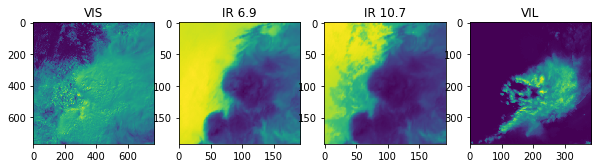

In [3]:
def read_data( sample_event, img_type, data_home ):
    """
    Reads single SEVIR event for a given image type.  
    """
    fn = sample_event[sample_event.img_type==img_type].squeeze().file_name
    fi = sample_event[sample_event.img_type==img_type].squeeze().file_index
    with h5py.File(data_home + '/' + fn,'r') as hf:
        data      = hf[img_type][fi] 
    return data

data_home = '../data' #  Modify if stored somewhere else 
vis = read_data( sample_event, 'vis', data_home)
ir069 = read_data( sample_event, 'ir069', data_home)
ir107 = read_data( sample_event, 'ir107', data_home)
vil = read_data( sample_event, 'vil', data_home)

# plot a frame from each img_type
fig,axs = plt.subplots(1,4,figsize=(10,5))
frame_idx = 30
axs[0].imshow(vis[:,:,frame_idx]), axs[0].set_title('VIS')
axs[1].imshow(ir069[:,:,frame_idx]), axs[1].set_title('IR 6.9')
axs[2].imshow(ir107[:,:,frame_idx]), axs[2].set_title('IR 10.7')
axs[3].imshow(vil[:,:,frame_idx]), axs[3].set_title('VIL')


#### Including Lightning

To include lightning in this example, we first need to convert it to a raster type.  The following code shows how to do this by converting the flash data into the number of times a flash occurs in each pixel of an image.


(<matplotlib.image.AxesImage at 0x150a8a5c4080>, Text(0.5, 1.0, 'Lightning'))

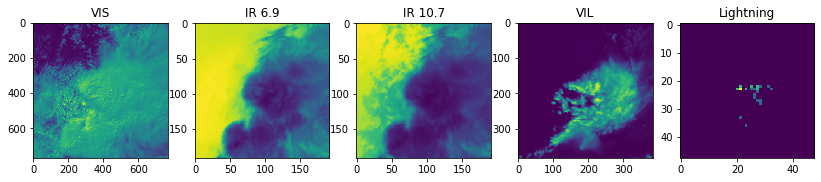

In [8]:
import numpy as np
def lght_to_grid(data):
    """
    Converts SEVIR lightning data stored in Nx5 matrix to an LxLx49 representing
    flash counts in each pixel at each time
    """
    FRAME_TIMES = np.arange(-120.0,120.0,5) * 60 # in seconds
    out_size = (48,48,len(FRAME_TIMES))
    if data.shape[0]==0:
        return np.zeros(out_size,dtype=np.float32)

    # filter out points outside the grid
    x,y=data[:,3],data[:,4]
    m=np.logical_and.reduce( [x>=0,x<out_size[0],y>=0,y<out_size[1]] )
    data=data[m,:]
    if data.shape[0]==0:
        return np.zeros(out_size,dtype=np.float32)

    # Filter/separate times
    # compute z coodinate based on bin locaiton times
    t=data[:,0]
    z=np.digitize(t,FRAME_TIMES)-1
    z[z==-1]=0 # special case:  frame 0 uses lght from frame 1

    x=data[:,3].astype(np.int64)
    y=data[:,4].astype(np.int64)

    k=np.ravel_multi_index(np.array([y,x,z]),out_size)
    n = np.bincount(k,minlength=np.prod(out_size))
    return np.reshape(n,out_size).astype(np.float32)

def read_lght_data( sample_event, data_home ):
    """
    Reads lght data from SEVIR and maps flash counts onto a grid  
    """
    fn = sample_event[sample_event.img_type=='lght'].squeeze().file_name
    id = sample_event[sample_event.img_type=='lght'].squeeze().id
    with h5py.File(data_home + '/' + fn,'r') as hf:
        data      = hf[id][:] 
    return lght_to_grid(data)

lght = read_lght_data( sample_event, data_home)

# include lightning counts in plot
fig,axs = plt.subplots(1,5,figsize=(14,5))
frame_idx = 30
axs[0].imshow(vis[:,:,frame_idx]), axs[0].set_title('VIS')
axs[1].imshow(ir069[:,:,frame_idx]), axs[1].set_title('IR 6.9')
axs[2].imshow(ir107[:,:,frame_idx]), axs[2].set_title('IR 10.7')
axs[3].imshow(vil[:,:,frame_idx]), axs[3].set_title('VIL')
axs[4].imshow(lght[:,:,frame_idx]), axs[4].set_title('Lightning')



#### Adding some color

All of the images in SEVIR are single-channel grey scale images.  To display colorized images similar to those seen in Figure 1, colormaps are available in the repo located here: https://github.com/MIT-AI-Accelerator/eie-sevir.  This code assumes the module `sevir` is in your path:

In [5]:
import sys
sys.path.append('/home/gridsan/mveillette/sandbox/sevir/')

(<matplotlib.image.AxesImage at 0x150ac81620f0>, Text(0.5, 1.0, 'Lightning'))

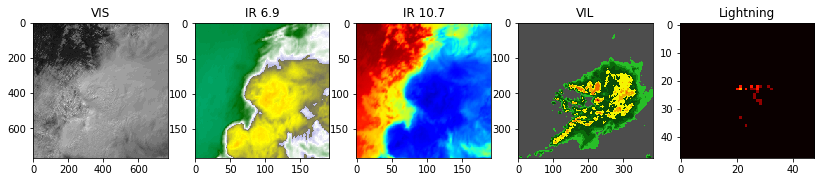

In [7]:
from sevir.display import get_cmap
# Get colormaps for encoded types
vis_cmap,vis_norm,vis_vmin,vis_vmax = get_cmap('vis',encoded=True)
ir069_cmap,ir069_norm,ir069_vmin,ir069_vmax = get_cmap('ir069',encoded=True)
ir107_cmap,ir107_norm,ir107_vmin,ir107_vmax = get_cmap('ir107',encoded=True)
vil_cmap,vil_norm,vil_vmin,vil_vmax = get_cmap('vil',encoded=True)
lght_cmap,lght_norm,lght_vmin,lght_vmax = get_cmap('lght',encoded=True)

fig,axs = plt.subplots(1,5,figsize=(14,5))
frame_idx = 30
axs[0].imshow(vis[:,:,frame_idx],cmap=vis_cmap,norm=vis_norm,vmin=vis_vmin,vmax=vis_vmax), axs[0].set_title('VIS')
axs[1].imshow(ir069[:,:,frame_idx],cmap=ir069_cmap,norm=ir069_norm,vmin=ir069_vmin,vmax=ir069_vmax), axs[1].set_title('IR 6.9')
axs[2].imshow(ir107[:,:,frame_idx],cmap=ir107_cmap,norm=ir107_norm,vmin=ir107_vmin,vmax=ir107_vmax), axs[2].set_title('IR 10.7')
axs[3].imshow(vil[:,:,frame_idx],cmap=vil_cmap,norm=vil_norm,vmin=vil_vmin,vmax=vil_vmax), axs[3].set_title('VIL')
axs[4].imshow(lght[:,:,frame_idx],cmap=lght_cmap,norm=lght_norm,vmin=lght_vmin,vmax=lght_vmax), axs[4].set_title('Lightning')


#### Adding geographical information

To include additional geographic information, such as US state lines, it is necessary to georeference the patches in a SEVIR event.  To do this, the catalog provides the projection as well as the corner latitude and longitudes. 

Currently, all patches in SEVIR use the same map projection, a Lambert Equal Area projection centered at (lat,lon)=(38,-98):


In [12]:
sample_event.proj.values[0]

'+proj=laea +lat_0=38 +lon_0=-98 +units=m +a=6370997.0 +ellps=sphere '

Using this, the latitude and longitude of each pixel of a patch can be computed:

In [ ]:
def laea(x,y,inverse=False):
    """
    Converts x,y to/from projection coordinates 
    """
    R=6370997.0
    

def get_lat_lon_grid( event ):
    """
    Computes lat/lon grid for an event (row from the catalog)
    """
    lower_left_

Based on this The example below shows how to georeference the above example using the `basemap` module.

In [9]:
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

## Addtional resources <a class="anchor" id="additional"></a>


* NOAA's Storm Event Database download links:  https://www.ncdc.noaa.gov/stormevents/ftp.jsp
